In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from statsmodels.tsa.arima.model import ARIMA
import itertools
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [102]:
# Fill categorical missing values with 'Unknown'
df = pd.read_csv('cleaned_data_dropped.csv',low_memory=False)
categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['FACILITY NAME', 'ST', 'INDUSTRY SECTOR', 'CHEMICAL',
       'CLEAN AIR ACT CHEMICAL', 'CLASSIFICATION', 'METAL', 'METAL CATEGORY',
       'CARCINOGEN', 'PBT', 'PFAS', 'UNIT OF MEASURE'],
      dtype='object')


In [103]:
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_counts

CLEAN AIR ACT CHEMICAL      6736
CLASSIFICATION              6736
METAL                       6736
METAL CATEGORY              6736
CARCINOGEN                  6736
PBT                         6736
PFAS                        6736
UNIT OF MEASURE             6736
PRODUCTION RATIO          226847
dtype: int64

<Figure size 1400x800 with 0 Axes>

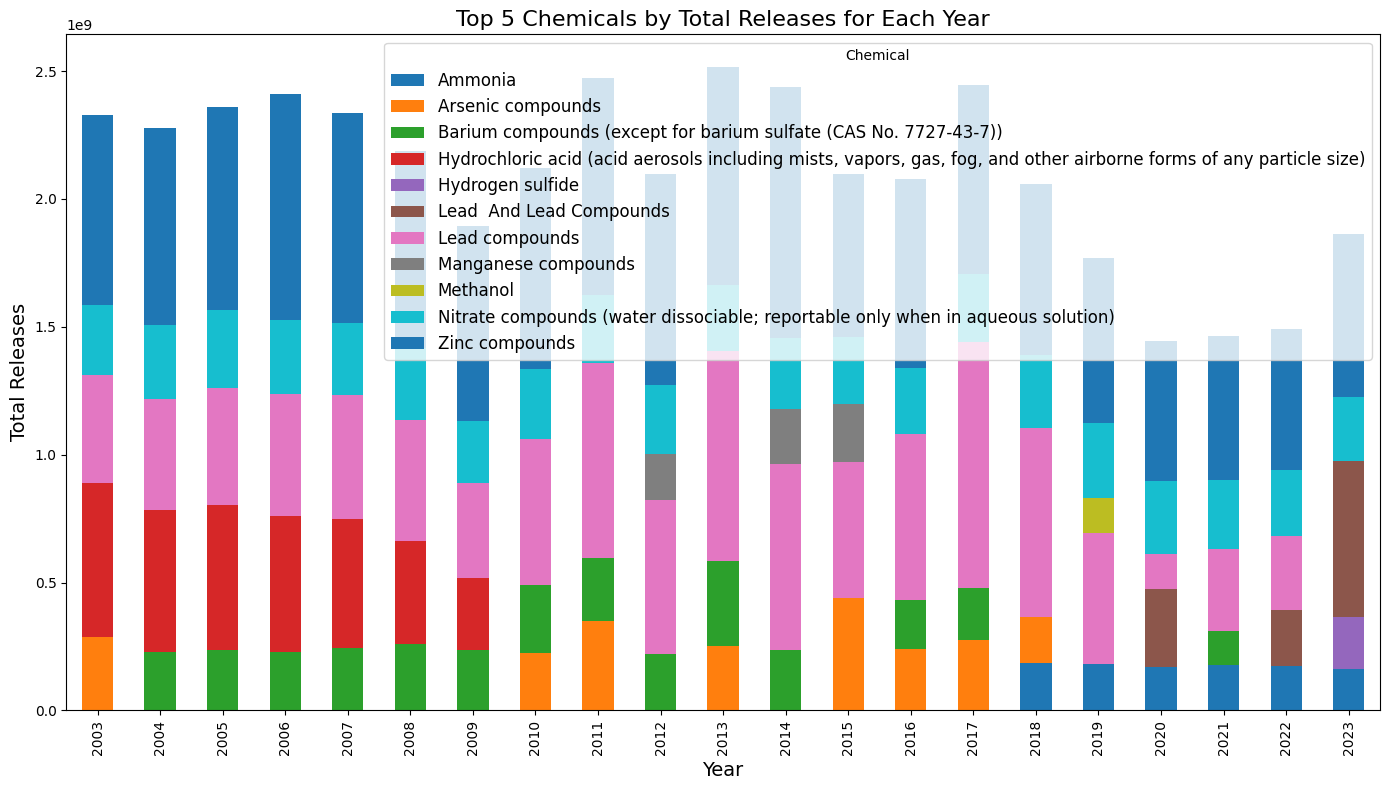

In [104]:
# Step 1: Group the data by YEAR and CHEMICAL, and calculate total releases for each chemical in each year
df_grouped = df.groupby(['YEAR', 'CHEMICAL'])['TOTAL RELEASES'].sum().reset_index()

# Step 2: Identify top 5 chemicals for each year
top_chemicals_by_year = (
    df_grouped.sort_values(['YEAR', 'TOTAL RELEASES'], ascending=[True, False])
    .groupby('YEAR')
    .head(5)
)

# Step 3: Pivot the data for visualization
top_chemicals_pivot = top_chemicals_by_year.pivot(index='YEAR', columns='CHEMICAL', values='TOTAL RELEASES')
# Step 4: Plot the top 5 chemicals for each year
plt.figure(figsize=(14, 8))
top_chemicals_pivot.plot(kind='bar', stacked=True, figsize=(14, 8))

plt.title('Top 5 Chemicals by Total Releases for Each Year', fontsize=16)
plt.ylabel('Total Releases', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend(title='Chemical', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


<Figure size 1400x800 with 0 Axes>

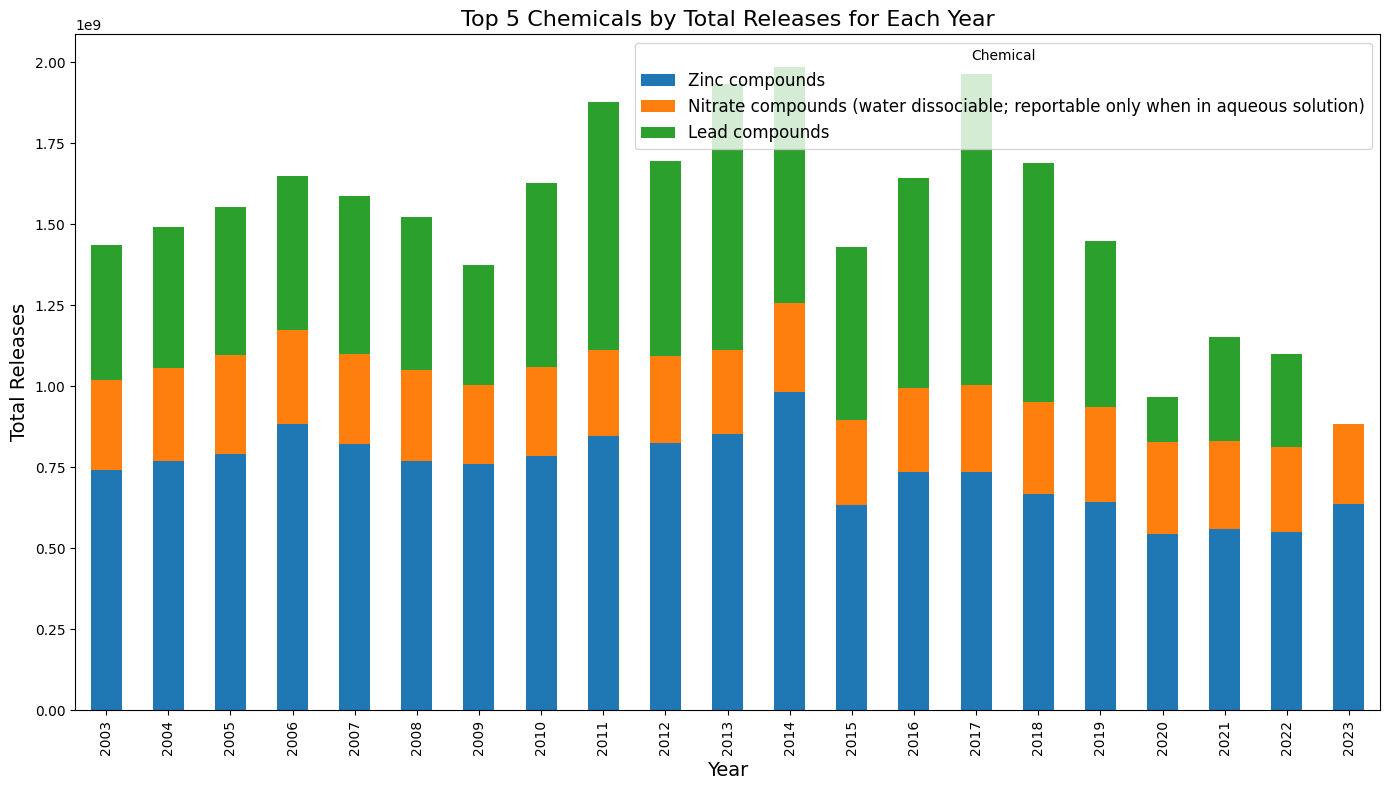

In [105]:
most_common_produced_chemicals = [ "Zinc compounds", "Nitrate compounds (water dissociable; reportable only when in aqueous solution)","Lead compounds"]
# Step 1: Group the data by YEAR and CHEMICAL, and calculate total releases for each chemical in each year
df_grouped = df.groupby(['YEAR', 'CHEMICAL'])['TOTAL RELEASES'].sum().reset_index()

# Step 2: Identify top 5 chemicals for each year
top_chemicals_by_year = (
    df_grouped.sort_values(['YEAR', 'TOTAL RELEASES'], ascending=[True, False])
    .groupby('YEAR')
    .head(5)
)

# Step 3: Pivot the data for visualization
top_chemicals_pivot = top_chemicals_by_year.pivot(index='YEAR', columns='CHEMICAL', values='TOTAL RELEASES')

# Step 4: Plot the top 5 chemicals for each year
plt.figure(figsize=(14, 8))
top_chemicals_pivot[most_common_produced_chemicals].plot(kind='bar', stacked=True, figsize=(14, 8))

plt.title('Top 5 Chemicals by Total Releases for Each Year', fontsize=16)
plt.ylabel('Total Releases', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend(title='Chemical', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [106]:
def error_percentage(y_true, y_pred):
    """
    Calculate the error percentage using NumPy.

    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values

    Returns:
    float: Error percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    errors = np.abs((y_true - y_pred) / y_true)
    return np.mean(errors) * 100

In [107]:
def sarima_model_implementation(time_series_data, test_start, test_end, train_data, test_data, actual_values, chemical):
    warnings.filterwarnings('ignore')

    # Define parameter grid for SARIMA
    p = d = q = range(0, 3)  # Non-seasonal params
    P = D = Q = range(0, 2)  # Seasonal params
    s = [12]  # Seasonal period (yearly data)

    # Create all combinations
    param_grid = list(product(p, d, q, P, D, Q, s))

    # Track best parameters
    best_rmse_SARIMA = float("inf")
    best_maep_SARIMA = float("inf")
    best_params = None
    if chemical == "Lead compounds":
        train_data = time_series_data["TOTAL RELEASES_diff"].dropna()[:-6]
    else:
        train_data = time_series_data["TOTAL RELEASES_diff"].dropna()[:-4]
    # Grid search
    for params in param_grid:
        try:
            sarima_model = SARIMAX(train_data,
                                order=(params[0], params[1], params[2]),
                                seasonal_order=(params[3], params[4], params[5], params[6]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
            results = sarima_model.fit(disp=False)
            # Predict and evaluate
            predictions = results.predict(start=test_start, end=test_end)
            rmse = np.sqrt(mean_squared_error(actual_values, predictions))
            maep = error_percentage(actual_values, predictions)
            if rmse < best_rmse_SARIMA:
                best_rmse_SARIMA = rmse
                best_params = params
                best_maep_SARIMA = maep
        except Exception as e:
            continue

    p, d, q, P, D, Q, s = best_params
    print(f'Best SARIMA Parameters: {best_params}')
    print(f'Best RMSE: {best_rmse_SARIMA}')
    # print(f'Best MAEP: {best_maep_SARIMA}')
    # Refit the model using the best parameters
    best_model = SARIMAX(
        time_series_data["TOTAL RELEASES_diff"].dropna(), 
        order=(p, d, q),        # (p, d, q)
        seasonal_order=(P, D, Q, s),  # (P, D, Q, s)
        enforce_stationarity=False, 
        enforce_invertibility=False
    )

    best_model_fitted = best_model.fit(disp=False)
    # print(best_model_fitted.summary())
    # Forecast for the next 5 years (60 months)
    forecast_steps = 5 * 12  # 5 years
    forecast = best_model_fitted.forecast(steps=forecast_steps)
    return forecast

def plot_forecast(forecast, time_series_data):
    forecast_steps = 5 * 12
    # Create a date range for the forecast
    forecast_index = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='MS')
    forecast_series = pd.Series(forecast, index=forecast_index)
    forecast_series = forecast_series.dropna()
    # Print the forecasted values
    # print(forecast_series)
    historical_df = time_series_data["TOTAL RELEASES_diff"].dropna().reset_index()
    historical_df.columns = ['YEAR', 'ACTUAL']
    # Display forecasted values
    future_years = pd.date_range(start=time_series_data["TOTAL RELEASES_diff"].dropna().index[-1] + pd.DateOffset(years=1), periods=5, freq='Y')
    forecast_df = pd.DataFrame({'YEAR': future_years, 'FORECAST': forecast_series})
    # print(forecast_df)
    return forecast_series

    # plt.figure(figsize=(12, 6))
    # # Plot historical data
    # plt.plot(historical_df['YEAR'], historical_df['ACTUAL'], label='Historical Data', marker='o', color='blue')
    # # Plot forecasted data
    # plt.plot([historical_df['YEAR'].iloc[-1]] + forecast_df['YEAR'].tolist(), 
    #         [historical_df['ACTUAL'].iloc[-1]] + forecast_df['FORECAST'].tolist(), 
    #         label='Forecasted Data', marker='x', linestyle='--', color='red')
    # plt.title('Forecast for the Next 5 Years')
    # plt.xlabel('Time')
    # plt.ylabel("TOTAL RELEASES")
    # plt.legend()
    # plt.show()



In [108]:
def change_from_differencing_to_original_values(time_series_data, forecast, chemical):
    # Inverse the differencing to return to the original scale
    last_value = time_series_data["TOTAL RELEASES"].iloc[-1]
    forecast_original_scale = forecast.cumsum() + last_value  
    print("Converted values", forecast_original_scale)
    historical_df = time_series_data["TOTAL RELEASES"].dropna().reset_index()
    historical_df.columns = ['YEAR', 'ACTUAL']
    # Display forecasted values
    future_years = pd.date_range(start=time_series_data["TOTAL RELEASES"].dropna().index[-1] + pd.DateOffset(years=1), periods=5, freq='Y')
    forecast_df = pd.DataFrame({'YEAR': future_years, 'FORECAST': forecast_original_scale})
#     print(forecast_df)

    plt.figure(figsize=(12, 6))
    # Plot historical data
    plt.plot(historical_df['YEAR'], historical_df['ACTUAL'], label='Historical Data', marker='o', color='blue')

    # Plot forecasted data
    plt.plot([historical_df['YEAR'].iloc[-1]] + forecast_df['YEAR'].tolist(), 
            [historical_df['ACTUAL'].iloc[-1]] + forecast_df['FORECAST'].tolist(), 
            label='Forecasted Data', marker='x', linestyle='--', color='red')

    plt.title('Forecast {} for Next 5 Years'.format(chemical))
    plt.xlabel('Time')
    plt.ylabel("TOTAL RELEASES")
    plt.legend()
    plt.show()

---------------------------------Zinc compounds---------------------------------
ADF Statistic: -6.263605207227404
p-value: 4.1654828992368134e-08


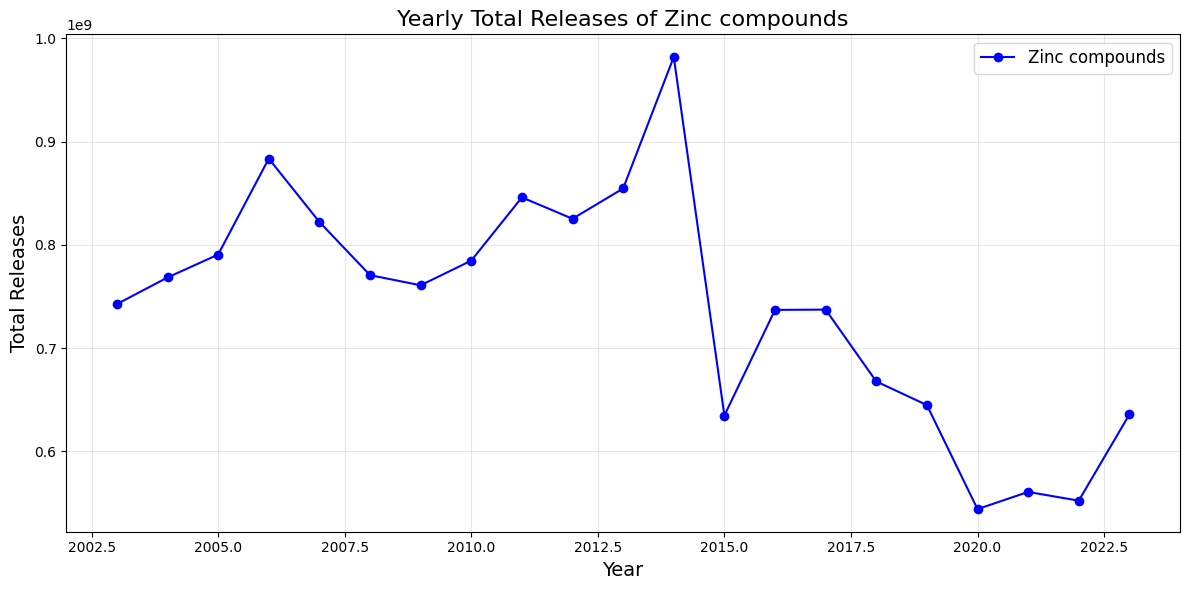

Q1 644913415.383
Q3 822262378.0500001
IQR 177348962.66700006
Outliers based on IQR:
Empty DataFrame
Columns: [TOTAL RELEASES, TOTAL RELEASES_diff]
Index: []


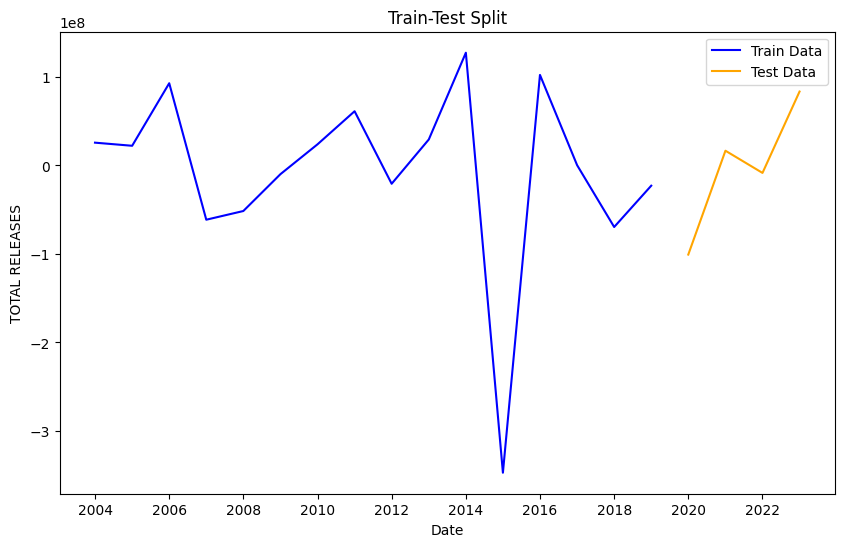

Best SARIMA Parameters: (1, 1, 0, 0, 1, 0, 12)
Best RMSE: 30392464.17079396
Converted values 2024-01-01    6.082264e+08
2025-01-01    6.462207e+08
2026-01-01    7.739273e+08
2027-01-01    4.314875e+08
2028-01-01    5.361824e+08
Name: predicted_mean, dtype: float64


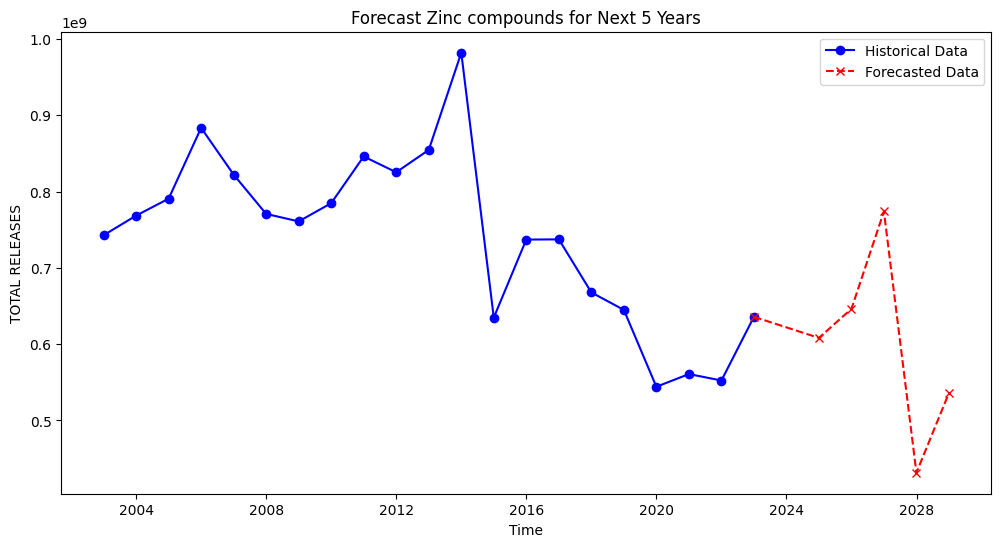

----------------------------------------------------------------------------------------------------
---------------------------------Nitrate compounds (water dissociable; reportable only when in aqueous solution)---------------------------------
ADF Statistic: -1.7350175975133693
p-value: 0.41316661625565637


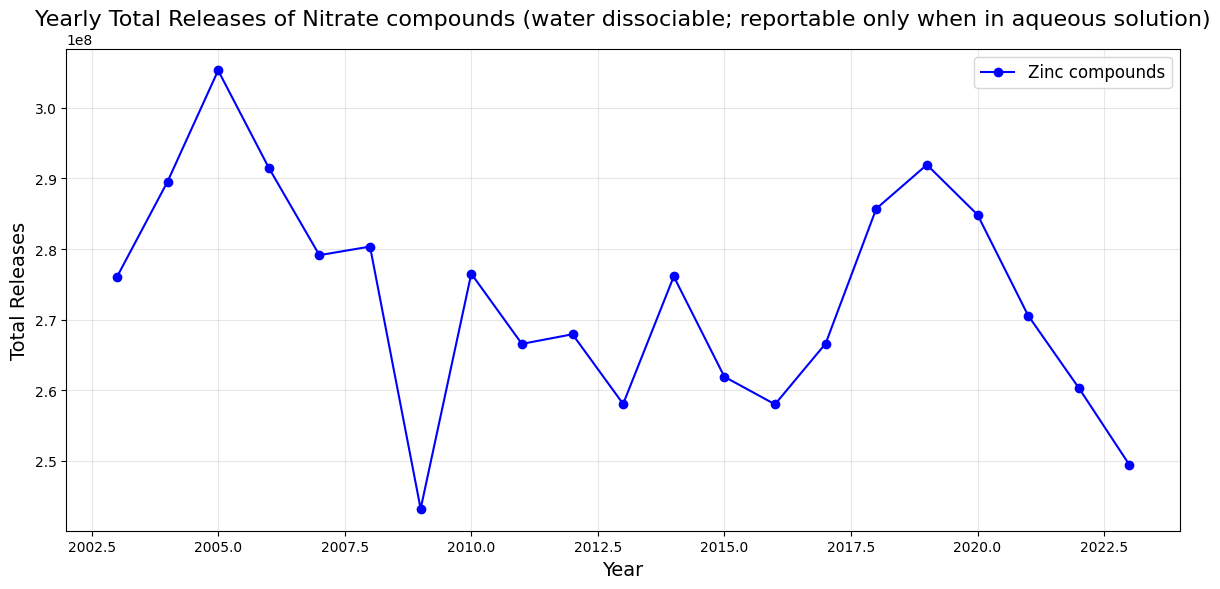

Q1 261918105.702
Q3 284869141.307
IQR 22951035.60499999
Outliers based on IQR:
Empty DataFrame
Columns: [TOTAL RELEASES, TOTAL RELEASES_diff]
Index: []


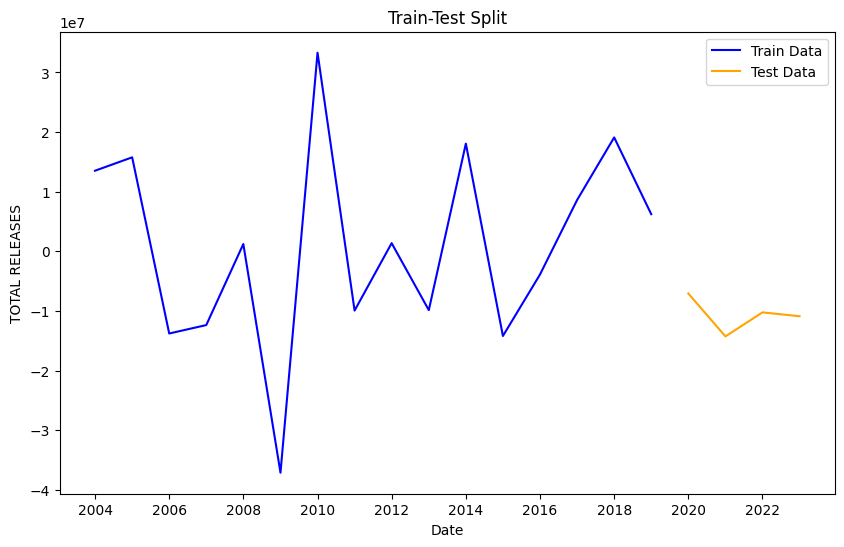

Best SARIMA Parameters: (2, 0, 2, 0, 0, 0, 12)
Best RMSE: 8897615.051669158
Converted values 2024-01-01    2.539160e+08
2025-01-01    2.558934e+08
2026-01-01    2.578854e+08
2027-01-01    2.586285e+08
2028-01-01    2.595341e+08
Name: predicted_mean, dtype: float64


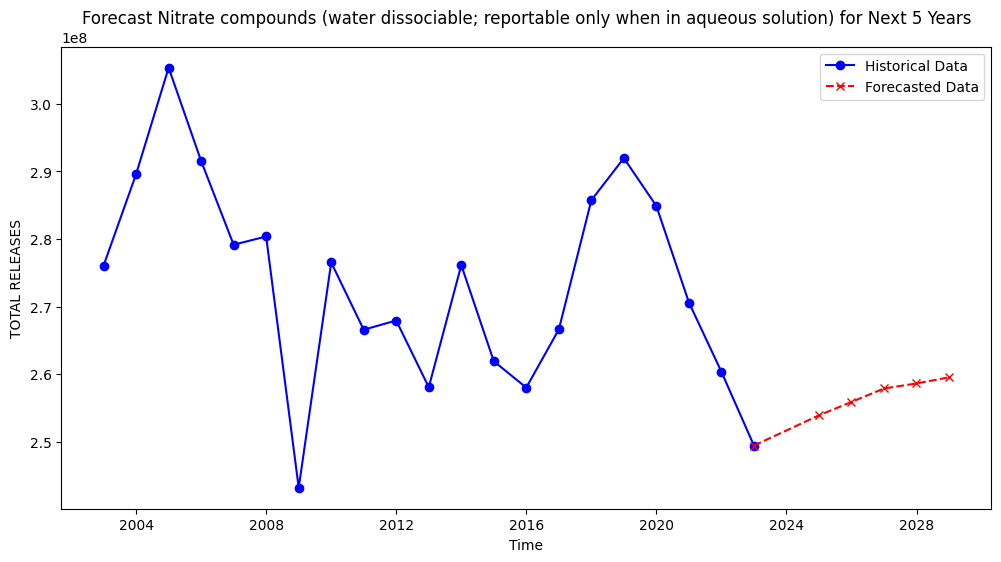

----------------------------------------------------------------------------------------------------
---------------------------------Lead compounds---------------------------------
ADF Statistic: -4.261366029510593
p-value: 0.0005178505242354465


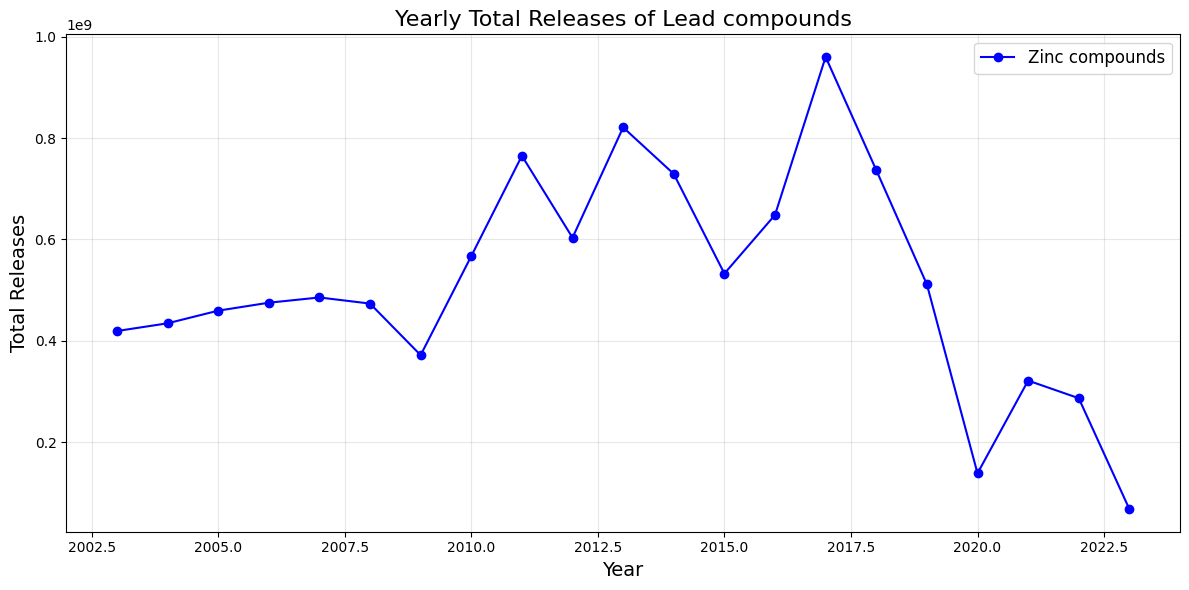

Q1 419241882.847
Q3 648469785.957
IQR 229227903.11
Outliers based on IQR:
            TOTAL RELEASES  TOTAL RELEASES_diff
YEAR                                           
2023-01-01     67636388.11        -2.189834e+08


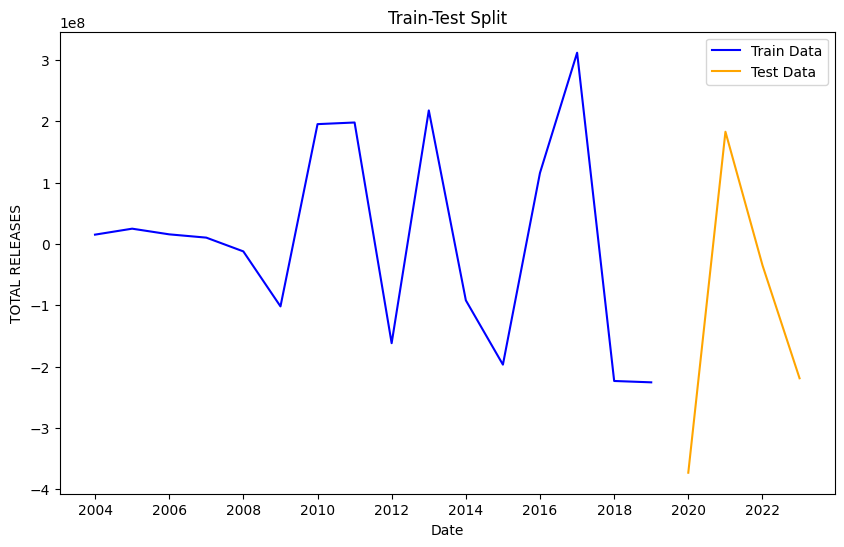

Best SARIMA Parameters: (0, 1, 2, 0, 0, 1, 12)
Best RMSE: 209055961.50624806
Converted values 2024-01-01    3.883662e+08
2025-01-01    2.359091e+08
2026-01-01    4.446784e+08
2027-01-01    7.757294e+08
2028-01-01    7.422198e+08
Name: predicted_mean, dtype: float64


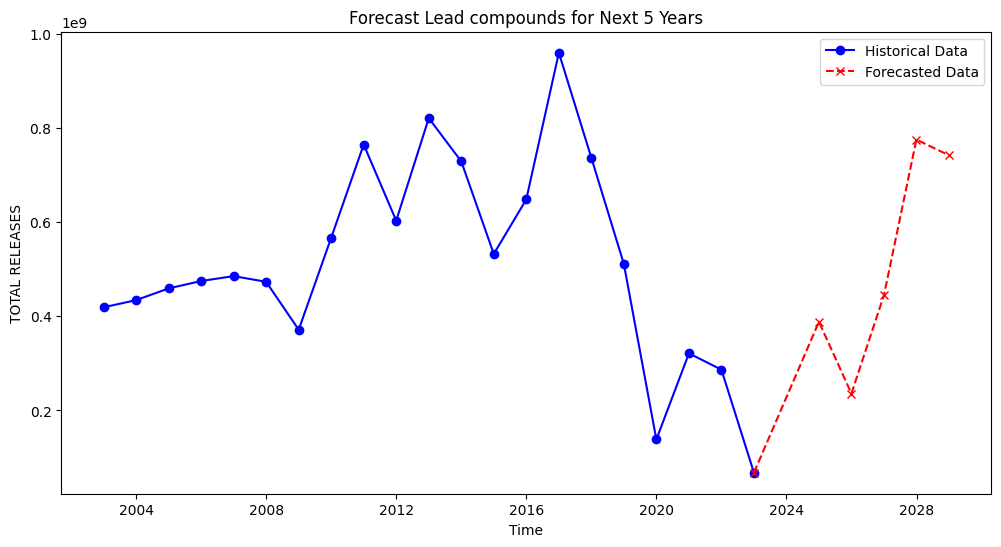

----------------------------------------------------------------------------------------------------


In [109]:
# Aggregate by year (if not already aggregated)
for chemical in most_common_produced_chemicals:
    print("---------------------------------{}---------------------------------".format(chemical))
    data = df_grouped[df_grouped["CHEMICAL"] == chemical]
    time_series_data = data.groupby("YEAR")["TOTAL RELEASES"].sum().reset_index()
    yearly_releases = time_series_data.copy()
    # Ensure the YEAR column is a datetime type
    time_series_data['YEAR'] = pd.to_datetime(time_series_data['YEAR'], format='%Y')
    # Step 1: Check stationarity and transform if needed
    time_series_data["TOTAL RELEASES_diff"] = time_series_data["TOTAL RELEASES"].diff().dropna()

    # ADF test for stationarity
    adf_test = adfuller(time_series_data["TOTAL RELEASES_diff"].dropna())
    print("ADF Statistic:", adf_test[0])
    print("p-value:", adf_test[1])
    outliers_detect = time_series_data.copy()
    # Set YEAR as the index for time-series analysis
    time_series_data.set_index('YEAR', inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(yearly_releases["YEAR"], yearly_releases["TOTAL RELEASES"], marker='o', color='blue', label="Zinc compounds")
    plt.title("Yearly Total Releases of {}".format(chemical), fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Total Releases", fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    # Display the data
    # print(time_series_data.head())
    # print(time_series_data.columns)
    # print(outliers_detect.columns)
    # Calculate IQR
    Q1 = time_series_data["TOTAL RELEASES"].quantile(0.25)
    Q3 = time_series_data["TOTAL RELEASES"].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = time_series_data[(time_series_data["TOTAL RELEASES"] < lower_bound) | 
                                (time_series_data["TOTAL RELEASES"] > upper_bound)]
    print("Q1", Q1)
    print("Q3", Q3)
    print("IQR", IQR)
    # print(time_series_data["TOTAL RELEASES"])
    print("Outliers based on IQR:")
    print(outliers)
    # Define split ratio (e.g., 80% train, 20% test)
    split_ratio = 0.8
    split_index = int(len(time_series_data["TOTAL RELEASES_diff"].dropna()) * split_ratio)

    # Split into train and test
    train_data = time_series_data["TOTAL RELEASES_diff"].dropna()[:split_index]
    test_data = time_series_data["TOTAL RELEASES_diff"].dropna()[split_index:]

    # Define test_start and test_end
    test_start = test_data.index[0]
    test_end = test_data.index[-1]
    # Extract actual values from the time series data for the test period
    actual_values = time_series_data["TOTAL RELEASES_diff"].dropna()[test_start:test_end]

    plt.figure(figsize=(10, 6))
    plt.plot(train_data, label='Train Data', color='blue')
    plt.plot(test_data, label='Test Data', color='orange')
    plt.xlabel('Date')
    plt.ylabel("TOTAL RELEASES")
    plt.title('Train-Test Split')
    plt.legend()
    plt.show()
    
    forecast = sarima_model_implementation(time_series_data, test_start, test_end, train_data, test_data, actual_values, chemical)
    forecast_series = plot_forecast(forecast, time_series_data)
    # print("forecast_series", forecast_series)
    change_from_differencing_to_original_values(time_series_data, forecast_series, chemical)
    print("----------------------------------------------------------------------------------------------------")
